In [ ]:
!pip install d2l==1.0.0-beta0

LeNet, AlexNet và VGG đều có chung một mẫu thiết kế: trích xuất các tính năng khai thác cấu trúc không gian thông qua một chuỗi các lớp tích chập và tổng hợp và xử lý hậu kỳ các biểu diễn thông qua các lớp được kết nối đầy đủ. Những cải tiến đối với LeNet của AlexNet và VGG chủ yếu nằm ở chiều rộng và chiều sâu của 2 module này.

Thiết kế này đặt ra hai thách thức lớn. Đầu tiên, các lớp được kết nối đầy đủ ở phần cuối của kiến ​​trúc tiêu thụ một số lượng lớn các tham số. Chẳng hạn, ngay cả một mô hình đơn giản như VGG-11 cũng yêu cầu một
ma trận $25088 \times 4096$, chiếm gần 400 MB RAM ở độ chính xác đơn (FP32). Đây là một trở ngại đáng kể đối với tính toán, đặc biệt là trên thiết bị di động và thiết bị nhúng. Rốt cuộc, ngay cả điện thoại di động cao cấp cũng không có nhiều hơn 8GB RAM. Vào thời điểm VGG được phát minh, đây là một thứ tự nhỏ hơn (iPhone 4S có 512 MB). Như vậy, sẽ rất khó để biện minh cho việc dành phần lớn bộ nhớ cho một bộ phân loại hình ảnh.

Thứ hai, cũng không thể thêm các lớp được kết nối đầy đủ sớm hơn trong mạng để tăng mức độ phi tuyến tính: làm như vậy sẽ phá hủy cấu trúc không gian và có khả năng yêu cầu nhiều bộ nhớ hơn.

Dùng các khối của Mạng trong Mạng (Network in Network - NiN) là một giải pháp thay thế khác. Ý tưởng này được đề xuất trong [Lin et al., 2013] dựa trên một thay đổi rất đơn giản — sử dụng MLP trên các kênh cho từng điểm ảnh riêng biệt.

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

#8.3.1. NiN Blocks

Hãy nhớ lại rằng đầu vào và đầu ra của các tầng tích chập là các mảng bốn chiều với các trục tương ứng với batch, kênh, chiều cao và chiều rộng. Đầu vào và đầu ra của các tầng kết nối đầy đủ thường là các mảng hai chiều tương ứng với batch và các đặc trưng. Ý tưởng chính của NiN là áp dụng một tầng kết nối đầy đủ tại mỗi vị trí điểm ảnh (theo chiều cao và chiều rộng). Nếu trọng số tại mỗi vị trí không gian được chia sẻ với nhau, ta có thể coi đây là một tầng chập $1×1$ (như được mô tả trong Section 6.4) hoặc như một tầng kết nối đầy đủ được áp dụng độc lập trên từng vị trí điểm ảnh. Nói theo một cách khác, ta có thể coi từng phần tử trong chiều không gian (chiều cao và chiều rộng) là tương đương với một mẫu và mỗi kênh tương đương với một đặc trưng. Fig. 7.3.1 minh họa sự khác biệt chính về cấu trúc giữa NiN và AlexNet, VGG cũng như các mạng khác.

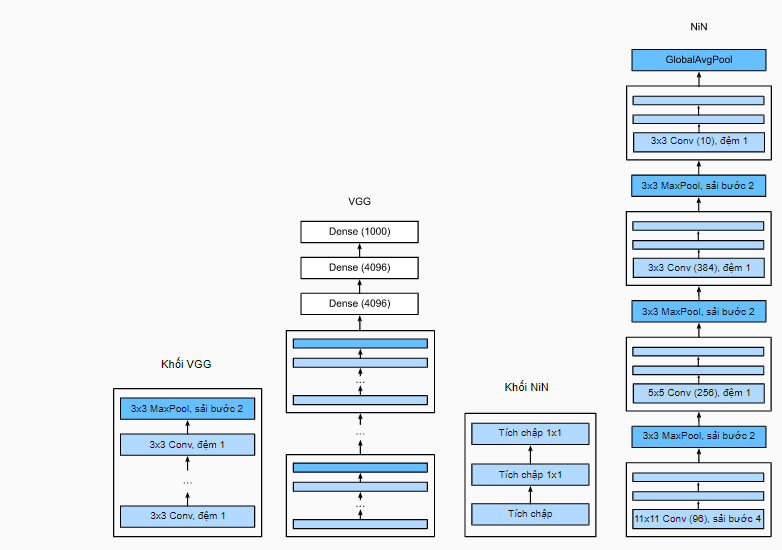

Khối NiN bao gồm một tầng tích chập theo sau bởi hai tầng tích chập $1×1$ hoạt động như các tầng kết nối đầy đủ trên điểm ảnh và sau đó là hàm kích hoạt ReLU. Kích thước cửa sổ tích chập của tầng thứ nhất thường được định nghĩa bởi người dùng. Kích thước cửa sổ tích chập ở các tầng tiếp theo được cố định bằng $1×1$.

In [ ]:
def nin_block(out_channels, kernel_size, strides, padding):
    return nn.Sequential(
        nn.LazyConv2d(out_channels, kernel_size, strides, padding), nn.ReLU(),
        nn.LazyConv2d(out_channels, kernel_size=1), nn.ReLU(),
        nn.LazyConv2d(out_channels, kernel_size=1), nn.ReLU())

# 8.3.2. Mô hình NiN

Cấu trúc mạng NiN gốc được đề xuất ngay sau và rõ ràng lấy cảm hứng từ mạng Alexnet. NiN sử dụng các tầng tích chập có kích thước cửa sổ  $11×11$, $5×5$, $3×3$, và số lượng các kênh đầu ra tương ứng giống với AlexNet. Mỗi khối NiN theo sau bởi một tầng gộp cực đại với sải bước 2 và kích thước cửa sổ $3×3$.

Một điểm khác biệt đáng chú ý so với AlexNet là NiN tránh hoàn toàn việc sử dụng các kết nối dày đặc. Thay vào đó, mạng này sử dụng các khối NiN với số kênh đầu ra bằng với số lớp nhãn, theo sau bởi một tầng gộp trung bình toàn cục, tạo ra một vector logit. Một lợi thế của thiết kế NiN là giảm được các tham số cần thiết của mô hình một cách đáng kể. Tuy nhiên, trong thực tế, cách thiết kế này đôi lúc đòi hỏi tăng thời gian huấn luyện mô hình.

In [ ]:
class NiN(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nin_block(96, kernel_size=11, strides=4, padding=0),
            nn.MaxPool2d(3, stride=2),
            nin_block(256, kernel_size=5, strides=1, padding=2),
            nn.MaxPool2d(3, stride=2),
            nin_block(384, kernel_size=3, strides=1, padding=1),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout(0.5),
            nin_block(num_classes, kernel_size=3, strides=1, padding=1),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten())
        self.net.apply(d2l.init_cnn)

Chúng ta tạo một mẫu dữ liệu để kiểm tra kích thước đầu ra của từng khối.

In [ ]:
NiN().layer_summary((1, 1, 224, 224))

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Sequential output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Sequential output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Sequential output shape:	 torch.Size([1, 384, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 384, 5, 5])
Dropout output shape:	 torch.Size([1, 384, 5, 5])
Sequential output shape:	 torch.Size([1, 10, 5, 5])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 10, 1, 1])
Flatten output shape:	 torch.Size([1, 10])


# 8.3.3. Training

Như trước đây, chúng ta sử dụng Fashion-MNIST để đào tạo mô hình bằng cách sử dụng cùng một trình tối ưu hóa mà chúng tôi đã sử dụng cho AlexNet và VGG.

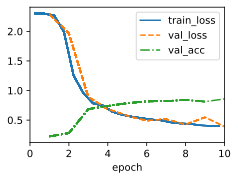

In [ ]:
model = NiN(lr=0.05)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(224, 224))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)